In [1]:
import os, sys
%pylab inline
plt.style.use("default")
plt.rcParams["figure.figsize"] = (12,5)

Populating the interactive namespace from numpy and matplotlib


In [174]:
def generate_data(n_ds = 1, x = None, n_obs = 10, noise_sd = 0.1, seed = 0):
    random.seed(seed)

    if x is None:
        x = np.linspace(0, 1, n_obs)
    else:
        n_obs = len(x)

    X, Y = [], []
    
    for i in range(n_ds):
        y = sin(2 * pi * x) + randn(n_obs) * noise_sd
        X.append(x)
        Y.append(y)

    return X, Y

def compute_features(x, n_feat = 24, feat_sd = 0.1):
    # Features are a set of Gaussian functions with means equally spaced in [0, 1]
    means = linspace(0, 1, n_feat)
    return array([0*x + 1] + [exp(-0.5 * (x - m)**2 / feat_sd**2) for m in means]).T

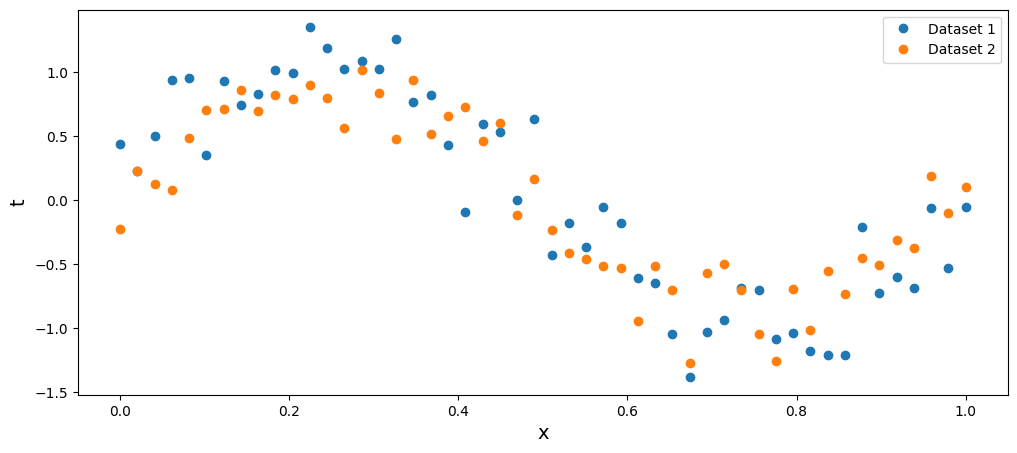

In [175]:
noise_sd = 0.25
X, Y = generate_data(n_ds = 10, n_obs = 50, noise_sd = noise_sd, seed = 0)
plot(X[0], Y[0], "o", label="Dataset 1")
plot(X[1], Y[1], "o", label="Dataset 2")
xlabel("x", fontsize=14); ylabel("t", fontsize=14); legend();


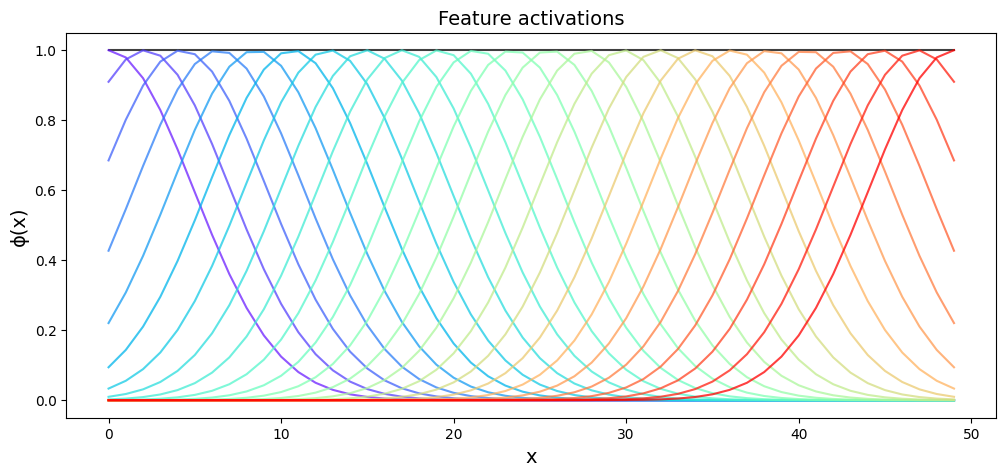

In [176]:
n_feat = 24
feat_sd = 0.1
Phi = compute_features(X[0], n_feat = n_feat, feat_sd = feat_sd) # Features are the same for all datasets
[plot(Phi_i, color="k" if i == 0 else cm.rainbow(i/n_feat), alpha=0.75) for i,Phi_i in enumerate(Phi.T)]
xlabel("x", fontsize=14); ylabel("ϕ(x)", fontsize=14); title("Feature activations", fontsize=14);

In [177]:
# Loss(w) = 1/2σ² * (y - w'ϕ(x))² + λ w'w/2
# ∇Loss(w) = -1/σ² * (y - w'ϕ(x))ϕ(x) + λw
#          = 0 -> w = (ϕ(x)'ϕ(x) + λσ²I)^-1 ϕ(x)'y
def solve(Phi, Y, noise_sd=1, λ=0):
    M = Phi.shape[1]
    I = eye(M)
    G = Phi.T @ Phi + λ * noise_sd**2 * I
    w_ds = [linalg.solve(G, Phi.T @ y) for y in Y]
    y_ds = [Phi @ w for w in w_ds]
    return w_ds, y_ds

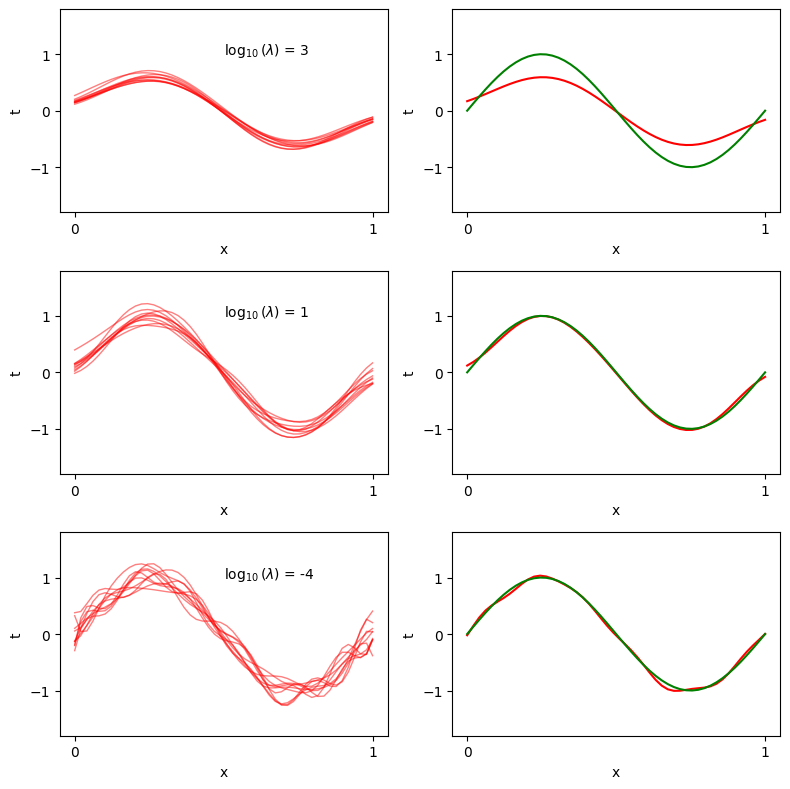

In [178]:
figure(figsize=(8, 8))
λ_vals = [5e2, 1e1, 1e-4]
for i, λ in enumerate(λ_vals):
    w_ds, y_ds = solve(Phi, Y, noise_sd = noise_sd, λ = λ)
    y_ds = array(y_ds).T

    subplot(3, 2, 2*i + 1)
    plot(X[0], y_ds, "r", lw=1, alpha=0.5)
    ylim(-1.8, 1.8)
    gca().set_xticks([0,1])
    xlabel("x"); ylabel("t");
    text(0.5, 1, "$\log_{10}(\\lambda)$ = " +f"{log10(λ):.1g}", ha="left")
    
    subplot(3, 2, 2*i + 2)
    plot(X[0], mean(y_ds, axis=1), "r"); ylim(-1.8, 1.8)
    plot(X[0], sin(2*pi*X[0]), "g")
    gca().set_xticks([0,1])    
    xlabel("x"); ylabel("t");
tight_layout()    



In [283]:
Xtrain, Ytrain = generate_data(n_ds = 100, n_obs = 25,      noise_sd = noise_sd, seed = 0)
Xtest,  Ytest  = generate_data(n_ds = 1,   n_obs = 1000,    noise_sd = noise_sd, seed = 1)

In [289]:
λ_vals = logspace(-1, 2, 51)
bias2 = []
variance = []
train_error = []
test_error = []
mse = []
for λ in λ_vals:
    Phi_train = compute_features(Xtrain[0], n_feat = n_feat, feat_sd = feat_sd)
    w_ds, y_ds = solve(Phi_train, Ytrain, noise_sd = noise_sd, λ = λ)

    y_ds    = array(y_ds).T # y_ds.shape = (n_obs, n_ds)

    train_error.append(mean((y_ds - array(Ytrain).T)**2))
    
    y_mean  = mean(y_ds, axis=1) # Mean over datasets, y_mean.shape = (n_obs,)

    h_train = sin(2*pi*Xtrain[0]) # True function

    bias_per_obs = (y_mean - h_train)
    bias2.append(mean(bias_per_obs**2))

    var_per_obs = var(y_ds, axis=1) # Variance over datasets, var_per_obs.shape = (n_obs,)    
    variance.append(mean(var_per_obs))

    se_per_obs = (y_ds - h_train[:, None])**2 # Squared error per observation
    mse_per_ds = mean(se_per_obs, axis=0) # Mean squared error over observations, mse_per_ds.shape = (n_ds,)
    mse.append(mean(mean(se_per_obs)))
    
    Phi_test = compute_features(Xtest[0], n_feat = n_feat, feat_sd = feat_sd)
    y_test = Phi_test @ array(w_ds).T # Compute test values using the weights found for each training set
    test_error.append(mean((y_test - sin(2*pi*Xtest[0])[:, None])**2))

In [285]:
assert allclose(array(bias2) + array(variance), mse), "Bias² + Variance != MSE"

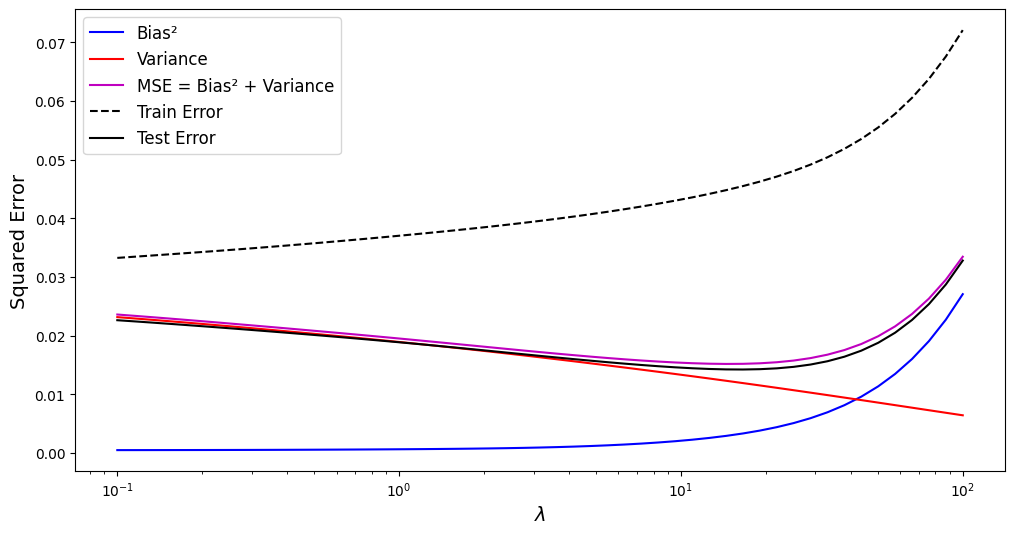

In [290]:
figure(figsize=(12, 6))
semilogx(λ_vals, bias2,      "b", label="Bias²")
semilogx(λ_vals, variance,   "r", label="Variance")
semilogx(λ_vals, mse,        "m", label="MSE = Bias² + Variance")
semilogx(λ_vals, train_error, "k--", label="Train Error")
semilogx(λ_vals, test_error,  "k", label="Test Error")
xlabel("$\lambda$", fontsize=14); ylabel("Squared Error", fontsize=14); legend(fontsize=12);